In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import itertools
import seaborn as sb
%matplotlib inline

/Users/thomaseffland/.virtualenvs/health/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data_fname = '../wnut_ner_evaluation/data/train_notypes'
xs, ys = [], []
with open(data_fname, 'r') as f:
    x, y = [], []
    for i, line in enumerate(f):
        split = line.split()
        if split:
            x.append(split[0])
            y.append(split[1])
        else: 
            xs.append(x)
            ys.append(y)
            x, y = [], []

data_fname = '../wnut_ner_evaluation/data/dev_notypes'
dev_xs, dev_ys = [], []
with open(data_fname, 'r') as f:
    x, y = [], []
    for i, line in enumerate(f):
        split = line.split()
        if split:
            x.append(split[0])
            y.append(split[1])
        else: 
            dev_xs.append(x)
            dev_ys.append(y)
            x, y = [], []

# Load in original data

In [3]:
from preprocess import *
from vocab import Vocab
from evaluation import macro_f1

In [4]:
""" A convenience vocabulary wrapper """
from collections import Counter
import numpy as np
import numpy.random as npr

class Vocab():
    def __init__(self, all_tokens=None, min_count=5):
        self.min_count=min_count

        if all_tokens:
            self.use(all_tokens)

        self.make_sampling_table()

    @property
    def n(self):
        return self._n

    @property
    def v(self):
        return self._v

    @property
    def pad(self):
        return '<PAD>'

    @property
    def ipad(self):
        return 0

    def idx(self, token):
        if token in self.vocabset:
            return self._vocab2idx[token]
        else:
            return self._vocab2idx['<UNK>']

    def token(self, idx):
        if idx in self.idxset:
            return self._idx2vocab[idx]
        else:
            return self._idx2vocab['<UNK>']

    def use(self, tokens):
        self.count_index = Counter()
        self._vocab2idx = {'<PAD>':0,
                           '<UNK>':1}
        self.add(tokens)

    def add(self, tokens):
        for token in tokens:
            self.count_index[token] += 1
        self._vocab2idx.update({token:i+2 for i, (token, count) in enumerate(self.count_index.most_common())
                                if count >= self.min_count})
        self._idx2vocab = {i:token for token, i in self._vocab2idx.items()}
        self.vocabset = set(self._vocab2idx.keys())
        self.idxset = set(self._idx2vocab.keys())
        self._n = sum( count for count in self.count_index.values() if count >= self.min_count)
        self._v = sum( 1 for count in self.count_index.values() if count >= self.min_count) + 2 # <PAD> and <UNK>

    def count(self, token):
        return self.count_index[token]

    def make_sampling_table(self, power_scalar=.75):
        # from 0 to V-1, get the frequency
        self.vocab_distribution = np.array([ (self.count_index[self._idx2vocab[idx]]/float(self._n))**power_scalar
                                    for idx in range(len(self.idxset))])
        self.vocab_distribution /= np.sum(self.vocab_distribution)

    def sample(self, sample_shape):
        # sample a tensor of indices
        # by walking up the CDF
        # setting each position to the index
        # of the word which is the closest
        # word with that CDF
        sums = np.zeros(sample_shape)
        rands = npr.uniform(size=sample_shape)
        idxs = np.zeros(sample_shape)
        for i in range(len(self.vocab_distribution)):
            sums += self.vocab_distribution[i]
            idxs[sums <= rands] = i
        return idxs.astype(np.int)


# Word Level Model

In [5]:
all_words = [ word for x in xs for word in x ]
all_labels = [l for y in ys for l in y ]
xvocab = Vocab(all_words, min_count=0)
yvocab = Vocab(all_labels, min_count=0)
print xvocab.n

46469


In [6]:
# do different weights
def label_weights(ys, weight_map):
    return [ [ weight_map[t] for t in y] for y in ys ]

weight_map = {}
for y in yvocab.vocabset:
    if y in ['O', '<UNK>']:
        weight_map[yvocab.idx(y)] = 1
    elif y in ['B', 'I']:
        weight_map[yvocab.idx(y)] = 2
    else:
        weight_map[yvocab.idx(y)] = 0

In [7]:
all_xs = xs + dev_xs
all_ys = ys + dev_ys

all_xs = sequences_to_indices(all_xs, xvocab)
all_xs, _, max_time = pad_sequences(all_xs, xvocab.ipad)

all_ys = sequences_to_indices(all_ys, yvocab)
all_ys, all_ws, _ = pad_sequences(all_ys, yvocab.ipad, weight_map=weight_map)

train_xs, test_xs = all_xs[:len(xs)], all_xs[len(xs):]
train_ws, test_ws = all_ws[:len(xs)], all_ws[len(xs):]
train_ys, test_ys = all_ys[:len(xs)], all_ys[len(xs):]

print max_time
print len(train_xs), len(test_xs)

41
2394 1000


In [8]:
print index_to_sequence(train_xs[1], xvocab)
print train_xs[1]

['Made', 'it', 'back', 'home', 'to', 'GA', '.', 'It', 'sucks', 'not', 'to', 'be', 'at', 'Disney', 'world', ',', 'but', 'its', 'good', 'to', 'be', 'home', '.', 'Time', 'to', 'start', 'planning', 'the', 'next', 'Disney', 'World', 'trip', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
[2926, 14, 104, 137, 5, 1073, 2, 80, 1287, 58, 5, 28, 27, 1762, 324, 3, 45, 103, 85, 5, 28, 137, 2, 167, 5, 219, 1904, 4, 90, 1762, 1039, 763, 2, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
print "y : ", index_to_sequence(train_ys[1], yvocab)
print yvocab._vocab2idx
print "y : ", train_ys[1]
print "w : ", train_ws[1]

y :  ['O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
{'I': 4, '<PAD>': 0, 'B': 3, 'O': 2, '<UNK>': 1}
y :  [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
w :  [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# from wordner import WordNER

from tfmodel import *

class WordNER(TFModel):
    def build_forward(self):
        # inputs
        self.x_input = tf.placeholder(tf.int32, [None, self.max_time])
        self.x_weight = tf.placeholder(tf.float32, [None, self.max_time])
        self.y_input = tf.placeholder(tf.int32, [None, self.max_time])
        self.dropout_keep = tf.placeholder(tf.float32)
        
        # embed and take weighted sum of character grams as word embedding
        self.word_vectors = tf.Variable(tf.random_uniform([self.xvocab.v, self.word_embed_size], 
                                                             -.1, .1, tf.float32))
        self.embedded_words = tf.nn.embedding_lookup(self.word_vectors, 
                                                         self.x_input)
        
        # split sequences
        embedded_list = [ tf.squeeze(t, [1]) for t in tf.split(1, self.max_time, self.embedded_words) ]
         
        # run GRU on sequence
        fw_cell = tf.nn.rnn_cell.GRUCell(self.hidden_size)
        outputs, _ = tf.nn.rnn(fw_cell, embedded_list, dtype=tf.float32)
        
        # softmax layer
        self.W = tf.Variable(tf.random_uniform([self.hidden_size, self.yvocab.v], 
                                              -.1, .1, tf.float32))
        self.b = tf.Variable(tf.zeros([self.yvocab.v]))
        
        self.logits = [ tf.matmul(output, self.W) + self.b for output in outputs ]
        self.labels = [ tf.argmax(logit, 1) for logit in self.logits ]
        
    def build_loss(self):
        # convert logits to lists
        targets = [tf.squeeze(t, [1]) for t in tf.split(1, self.max_time, self.y_input)]
        weights = [tf.squeeze(t, [1]) for t in tf.split(1, self.max_time, self.x_weight)]
        seq_loss = tf.nn.seq2seq.sequence_loss_by_example(self.logits,
                                                          targets,
                                                          weights)
        self.loss = tf.reduce_mean(seq_loss)
    
    def build_optimizer(self):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def partial_fit(self, x, y, measure_only=False):
        x_input, x_weight = zip(*x)
        feed_dict = {
            self.x_input:x_input,
            self.x_weight:x_weight,
            self.y_input:y,
            self.dropout_keep:1.-self.dropout
        }
        
        if measure_only:
            loss = self.session.run(self.loss, feed_dict)
        else:
            loss, _ = self.session.run([self.loss, self.train_op], feed_dict)
        return loss
    
    def predict(self, x):
        x_input, x_weight = zip(*x)
        feed_dict = {
            self.x_input:x_input,
            self.x_weight:x_weight,
            self.dropout_keep:1.
        }
        predictions = self.session.run(self.labels, feed_dict)
        return predictions

In [11]:
tf.reset_default_graph()
session = tf.InteractiveSession()

params = {
    'learning_rate':.001,
    'xvocab':xvocab,
    'yvocab':yvocab,
    'max_time':max_time,
    'word_embed_size':50,
    'hidden_size':50,
    'dropout':.25
}
ner = WordNER(session, **params)

Model Loading... Done


In [12]:
ner.fit(zip(train_xs, train_ws), train_ys, batch_size=64, n_epoch=10)


 Epoch 1/10 : Batch 38/38: Loss 0.4656
 Epoch 2/10 : Batch 38/38: Loss 0.5088
 Epoch 3/10 : Batch 38/38: Loss 0.3514
 Epoch 4/10 : Batch 38/38: Loss 0.3410
 Epoch 5/10 : Batch 38/38: Loss 0.2183
 Epoch 6/10 : Batch 38/38: Loss 0.2164
 Epoch 7/10 : Batch 38/38: Loss 0.2087
 Epoch 8/10 : Batch 38/38: Loss 0.1311
 Epoch 9/10 : Batch 38/38: Loss 0.2159
 Epoch 10/10 : Batch 38/38: Loss 0.0745


In [13]:
preds = ner.predict(zip(test_xs, test_ws))

In [14]:
target_ys = depad_sequences(test_ys, yvocab.ipad)
predictions = depad_sequences(preds, yvocab.ipad)

In [15]:
flat_targets = [ yvocab.token(t) for y in target_ys for t in y ]
flat_predictions = [ yvocab.token(p) for y in predictions for p in y ]

In [16]:
stats = macro_f1(flat_targets, flat_predictions)

In [17]:
print stats

{'macro_recall': 0.33088844831206593, 'macro_f1': 0.3260214675861916, 'macro_precision': 0.32578279357940376, 'scores': {'I': {'recall': 0.01284796573875803, 'support': 467, 'precision': 0.025423728813559324, 'f1': 0.01706970128022715}, 'B': {'recall': 0.006051437216338881, 'support': 661, 'precision': 0.021621621621621623, 'f1': 0.009456264775413371}, 'O': {'recall': 0.9737659419811009, 'support': 15133, 'precision': 0.9303030303030303, 'f1': 0.9515384367029343}}}


/Users/thomaseffland/.virtualenvs/health/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


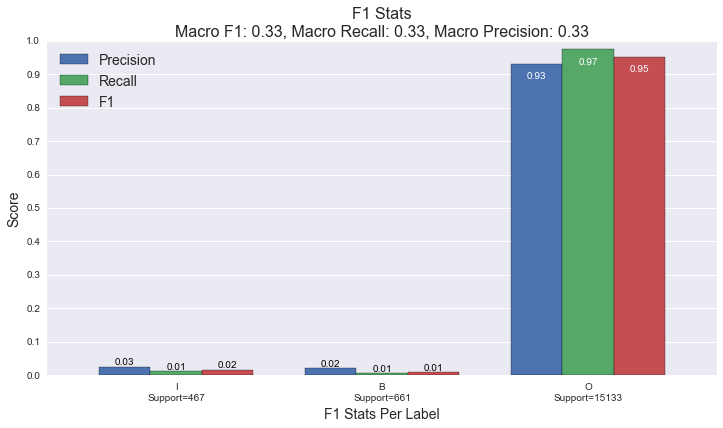

In [18]:
def plot_f1_stats(stats, bar_width=.25, colors=[], figsize=(12,6), title='F1 Stats'):
    # get colors if not explicit
    if not colors:
        palette = itertools.cycle(sb.color_palette())
        for i in range(3):
            colors.append(next(palette))

    # unpack the stats
    precisions = [ stat['precision'] for key, stat in stats['scores'].items() if key not in ['<UNK>', '<PAD>'] ]
    recalls = [ stat['recall'] for key, stat in stats['scores'].items() if key not in ['<UNK>', '<PAD>'] ]
    f1s = [ stat['f1'] for key, stat in stats['scores'].items() if key not in ['<UNK>', '<PAD>'] ]
    supports = [ stat['support'] for key, stat in stats['scores'].items() if key not in ['<UNK>', '<PAD>'] ]
    labels = [ '{}\nSupport={}'.format(label, support) 
              for label, support in zip(stats['scores'].keys(), supports) 
              if label not in ['<UNK>', '<PAD>']]

    
    # create the plot
    L = len([ label for label in stats['scores'].keys() if label not in ['<UNK>', '<PAD>'] ])
    idxs = np.arange(L)
    fig, ax = plt.subplots(figsize=figsize)
    
    # shrink actual plot 80% to left
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width, box.height* .9])
    
    # create bars
    prec_rects = ax.bar(idxs - bar_width, precisions, bar_width, color=colors[0])
    recall_rects = ax.bar(idxs, recalls, bar_width, color=colors[1])
    f1_rects = ax.bar(idxs + bar_width, f1s, bar_width, color=colors[2])
    
    # label the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if height < .9:
                rel_y = 1.05 * height 
                color = 'k'
            else:
                rel_y = .95 * height
                color = 'w'
            ax.text(rect.get_x() + rect.get_width()/2., rel_y,
                    '{0:.2f}'.format(height),
                    ha='center', va='bottom',
                    color=color)
    autolabel(prec_rects)
    autolabel(recall_rects)
    autolabel(f1_rects)
    
    # set ticks and labels
    ax.set_ylabel('Score', size=14)
    ax.set_yticks(.1 * np.arange(11))
    
    ax.set_xlabel('F1 Stats Per Label', size=14)
    ax.set_xticks(idxs +.5*bar_width)
    ax.set_xticklabels(labels)
    ax.xaxis.grid(False)
    ax.set_xlim(-2*bar_width, L-bar_width)
    
   
    
    # create the legend on top 10%
    ax.legend([prec_rects[0], recall_rects[0], f1_rects[0]],
              ['Precision', 'Recall', 'F1'], loc='best', fontsize=14)

    # create title and macro stats
    macro_labels = ", ".join(['Macro F1: {0:.2f}'.format(stats['macro_f1']),
                    'Macro Recall: {0:.2f}'.format(stats['macro_recall']),
                    'Macro Precision: {0:.2f}'.format(stats['macro_precision'])])
    ax.set_title(title+'\n'+macro_labels, size=16)
    
     
plot_f1_stats(stats)